# Overview, Credits, Genres and Keywords Based Recommender

### -  Data cleaning

C:\Users\JC\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


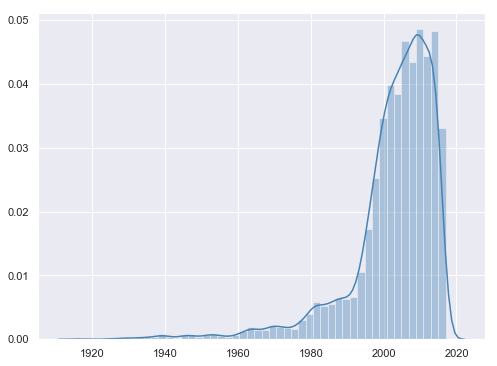

In [8]:
sns.set()
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(year, color='steelblue');

In [9]:
df2['release_latest']=df2['release_date'][4255] 
df2['release_latest'].head(2)

0   2017-02-03
1   2017-02-03
Name: release_latest, dtype: datetime64[ns]

In [10]:
df2['days']=(df2['release_latest']-df2['release_date']).dt.days+1
df2['days'].head()

0    2613
1    3549
2     467
3    1664
4    1795
Name: days, dtype: int64

In [11]:
from sklearn.preprocessing import StandardScaler
def standardize(df):   
    standardscaler = StandardScaler().fit(df)
    scaled = standardscaler.transform(df)
    return scaled

df2['year_standard']=standardize(year)

In [12]:
df2['year_standard'].head()

0    0.526158
1    0.365038
2    1.009520
3    0.767839
4    0.767839
Name: year_standard, dtype: float64

In [13]:
#Import TfIdfVectorizer from scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer

#Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
df2['overview'] = df2['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df2['overview'])

#Output the shape of tfidf_matrix
tfidf_matrix.shape

(4802, 20977)

In [14]:
# Parse the stringified features into their corresponding python objects
features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(literal_eval)

In [15]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [16]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [17]:
# Define new director, cast, genres and keywords features that are in a suitable form.
df2['director'] = df2['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    df2[feature] = df2[feature].apply(get_list)

In [18]:
# Print the new features of the first 3 films
df2[['title', 'cast', 'director', 'keywords', 'genres']].head(3)

,title,cast,director,keywords,genres
0,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weaver]",James Cameron,"[culture clash, future, space war]","[Action, Adventure, Fantasy]"
1,Pirates of the Caribbean: At World's End,"[Johnny Depp, Orlando Bloom, Keira Knightley]",Gore Verbinski,"[ocean, drug abuse, exotic island]","[Adventure, Fantasy, Action]"
2,Spectre,"[Daniel Craig, Christoph Waltz, Léa Seydoux]",Sam Mendes,"[spy, based on novel, secret agent]","[Action, Adventure, Crime]"


In [19]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [20]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    df2[feature] = df2[feature].apply(clean_data)

In [21]:
df2['director'].value_counts().shape

(2350,)

In [22]:
df2['cast'].value_counts().shape

(4697,)

In [23]:
df2.to_csv('tmdb_5000_movies_credits_cleaned.csv')

### Movie Overview Similarity

In [24]:
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim_overview = linear_kernel(tfidf_matrix, tfidf_matrix)

In [25]:
cosine_sim_overview

array([[1.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.02160043, 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.01487817, 0.        ,
        0.        ],
       ...,
       [0.        , 0.02160043, 0.01487817, ..., 1.        , 0.01608697,
        0.00701708],
       [0.        , 0.        , 0.        , ..., 0.01608697, 1.        ,
        0.01171577],
       [0.        , 0.        , 0.        , ..., 0.00701708, 0.01171577,
        1.        ]])

In [71]:
# np.savetxt("cosine_sim_overview.csv", cosine_sim_overview , delimiter=",")

### Director / Actor Similarity

In [26]:
def cast_director_list(x):
    return ' '.join(x['cast']) + ' ' + x['director'] 
df2['cast_director_list'] = df2.apply(cast_director_list, axis=1)

In [27]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['cast_director_list'])

In [28]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim_cast_director = cosine_similarity(count_matrix, count_matrix)

In [29]:
cosine_sim_cast_director

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [76]:
# np.savetxt("cosine_sim_cast_director.csv", cosine_sim_cast_director, delimiter=",")

### Genre Similarity

In [30]:
def genre_list(x):
    return ' '.join(x['genres'])
df2['genre_list'] = df2.apply(genre_list, axis=1)

In [31]:
count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(df2['genre_list'])

In [32]:
cosine_sim_genre = cosine_similarity(count_matrix, count_matrix)

In [33]:
cosine_sim_genre

array([[1.        , 1.        , 0.66666667, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 1.        , 0.66666667, ..., 0.        , 0.        ,
        0.        ],
       [0.66666667, 0.66666667, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [81]:
# np.savetxt("cosine_sim_genre.csv", cosine_sim_genre, delimiter=",")

### Mixed Similarity

In [34]:
cosine_sim_mixed=cosine_sim_genre+cosine_sim_cast_director+cosine_sim_overview

In [35]:
cosine_sim_mixed

array([[3.        , 1.        , 0.66666667, ..., 0.        , 0.        ,
        0.        ],
       [1.        , 3.        , 0.66666667, ..., 0.02160043, 0.        ,
        0.        ],
       [0.66666667, 0.66666667, 3.        , ..., 0.01487817, 0.        ,
        0.        ],
       ...,
       [0.        , 0.02160043, 0.01487817, ..., 3.        , 0.01608697,
        0.00701708],
       [0.        , 0.        , 0.        , ..., 0.01608697, 2.        ,
        0.01171577],
       [0.        , 0.        , 0.        , ..., 0.00701708, 0.01171577,
        3.        ]])

In [84]:
# np.savetxt("cosine_sim_mixed.csv", cosine_sim_mixed, delimiter=",")

### Recommender I - mixed matrix

In [36]:
#Construct a reverse map of indices and movie titles
indices = pd.Series(df2.index, index=df2['title']).drop_duplicates()

In [37]:
# Reset index of our main DataFrame and construct reverse mapping as before
df2 = df2.reset_index()
indices = pd.Series(df2.index, index=df2['title'])

In [39]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations_matrix(title, cosine_sim=cosine_sim_mixed): 
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 20 most similar movies
    sim_scores = sim_scores[1:21]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df2['title'].iloc[movie_indices]

In [40]:
get_recommendations_matrix('The Dark Knight Rises', cosine_sim_mixed)

119                             Batman Begins
65                            The Dark Knight
3073                        Romeo Is Bleeding
1196                             The Prestige
1253                            Kiss of Death
761                            Righteous Kill
1149                          American Hustle
1742                           Brick Mansions
3062                              Deuces Wild
2543                                 Cop Land
2388                               I Am Wrath
2154                             Street Kings
405     The Fast and the Furious: Tokyo Drift
1765                          The Newton Boys
3326                           Black November
1278                               The Gunman
3828                        Menace II Society
4663                                  Bronson
4408                           Jimmy and Judy
3074                                The Limey
Name: title, dtype: object

In [5]:
!pip install surprise

  Using cached https://files.pythonhosted.org/packages/61/de/e5cba8682201fcf9c3719a6fdda95693468ed061945493dea2dd37c5618b/surprise-0.1-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/4d/fc/cd4210b247d1dca421c25994740cbbf03c5e980e31881f10eaddf45fdab0/scikit-surprise-1.0.6.tar.gz
  Complete output from command C:\Users\cahib\Anaconda3\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\cahib\\AppData\\Local\\Temp\\pip-install-a9nt1ox7\\scikit-surprise\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" bdist_wheel -d C:\Users\cahib\AppData\Local\Temp\pip-wheel-8lmpe6nh --python-tag cp37:
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-3.7
  creating build\lib.win-amd64-3.7\surprise
  copying surprise\accuracy.py -> build\lib.win-amd64-3.7\surprise
  copying surprise\builtin_datasets.py -> build\lib.win-

  Failed building wheel for scikit-surprise
Command "C:\Users\cahib\Anaconda3\python.exe -u -c "import setuptools, tokenize;__file__='C:\\Users\\cahib\\AppData\\Local\\Temp\\pip-install-a9nt1ox7\\scikit-surprise\\setup.py';f=getattr(tokenize, 'open', open)(__file__);code=f.read().replace('\r\n', '\n');f.close();exec(compile(code, __file__, 'exec'))" install --record C:\Users\cahib\AppData\Local\Temp\pip-record-7j0g9v17\install-record.txt --single-version-externally-managed --compile" failed with error code 1 in C:\Users\cahib\AppData\Local\Temp\pip-install-a9nt1ox7\scikit-surprise\


### Recommender II - mixed matrix + rating

In [41]:
rating =pd.DataFrame(df2['vote_average'],index=df2.index)

In [42]:
rating.head()

,vote_average
0,7.2
1,6.9
2,6.3
3,7.6
4,6.1


In [43]:
from sklearn.preprocessing import StandardScaler
def standardize(df):   
    standardscaler = StandardScaler().fit(df)
    scaled = standardscaler.transform(df)
    return scaled
df2['vote_average_standard']=standardize(rating)
df2['vote_average_standard'].head()

##bad result

0    0.928811
1    0.677001
2    0.173380
3    1.264558
4    0.005506
Name: vote_average_standard, dtype: float64

In [44]:
rating_ = pd.Series(df2['vote_average']/df2['vote_average'].max(),index=df2.index)
rating_.head()

0    0.72
1    0.69
2    0.63
3    0.76
4    0.61
Name: vote_average, dtype: float64

In [45]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations_rating(title, cosine_sim=cosine_sim_mixed):
    # Get the index of the movie that matches the title
    idx = indices[title]
    rating = rating_[idx]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))+rating

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 20 most similar movies
    sim_scores = sim_scores[1:21]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df2['title'].iloc[movie_indices]

In [47]:
get_recommendations_rating('The Dark Knight Rises', cosine_sim_mixed)

119                             Batman Begins
65                            The Dark Knight
3073                        Romeo Is Bleeding
1196                             The Prestige
1253                            Kiss of Death
761                            Righteous Kill
1149                          American Hustle
1742                           Brick Mansions
3062                              Deuces Wild
2543                                 Cop Land
2388                               I Am Wrath
2154                             Street Kings
405     The Fast and the Furious: Tokyo Drift
1765                          The Newton Boys
3326                           Black November
1278                               The Gunman
3828                        Menace II Society
4663                                  Bronson
4408                           Jimmy and Judy
3074                                The Limey
Name: title, dtype: object

### Recommender III - mixed matrix + rating + year

In [48]:
year_list = pd.Series(df2['days'], index=df2.index)
year = np.array(df2['days'])

In [55]:
list(enumerate(cosine_sim_mixed[2]+1/abs(year_list-year[2]))) # generate index

[(0, 0.6671326498912707),
 (1, 0.6669911313000219),
 (2, inf),
 (3, 0.6675020885547203),
 (4, 0.6674196787148596),
 (5, 0.6669892473118282),
 (6, 0.0005564830272676684),
 (7, 0.7029628974442613),
 (8, 0.3585971183492162),
 (9, 0.67337807606264),
 (10, 0.6669601800215245),
 (11, 1.082146995357077),
 (12, 0.6669594924353345),
 (13, 0.6678500986193295),
 (14, 0.6678214010777523),
 (15, 0.33370098039215695),
 (16, 0.6674485274954394),
 (17, 0.7194292200255402),
 (18, 0.36752278420872336),
 (19, 0.6697916666666669),
 (20, 0.6674890350877195),
 (21, 0.8169983370742389),
 (22, 0.40971027876795657),
 (23, 0.6769239323077857),
 (24, 0.6669442131557037),
 (25, 0.00015264845061822624),
 (26, 0.6721014492753625),
 (27, 0.6674400618716165),
 (28, 0.6738609112709834),
 (29, 1.301690119692245),
 (30, 0.6669082125603867),
 (31, 0.6677524429967429),
 (32, 0.33381806430764266),
 (33, 0.6669571954290143),
 (34, 0.0011655011655011655),
 (35, 0.7428023719968636),
 (36, 0.6842330654468758),
 (37, 0.33437175

In [56]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations_rating_year(title, cosine_sim=cosine_sim_mixed):
    # Get the index of the movie that matches the title
    idx = indices[title]
    rating = rating_[idx]
    year_list_ = year_list
    year_ = year[idx]
    

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]+1/(abs(year_list_-year_+1))))+ rating

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 20 most similar movies
    sim_scores = sim_scores[1:21]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return df2['title'].iloc[movie_indices]

In [57]:
get_recommendations_rating_year('The Dark Knight Rises', cosine_sim_mixed)

119                             Batman Begins
65                            The Dark Knight
3073                        Romeo Is Bleeding
1196                             The Prestige
1253                            Kiss of Death
1149                          American Hustle
761                            Righteous Kill
1742                           Brick Mansions
3062                              Deuces Wild
3326                           Black November
3725                              The Sweeney
2543                                 Cop Land
2388                               I Am Wrath
2154                             Street Kings
405     The Fast and the Furious: Tokyo Drift
1765                          The Newton Boys
1278                               The Gunman
3828                        Menace II Society
4663                                  Bronson
4408                           Jimmy and Judy
Name: title, dtype: object